## 1.4.1 ベイズ推論をプログラムする

In [2]:
import numpy as np

In [6]:
# クリック率を離散値とする
thetas = np.linspace(0,1,1001)
print(thetas)

[0.    0.001 0.002 ... 0.998 0.999 1.   ]


In [13]:
# 尤度関数
# r = 1のとき thetas 0のとき 1-thetas
likelihood = lambda r: thetas if r else (1 -thetas)

In [14]:
# 事後分布
def posterior(r,prior):
    lp = likelihood(r) * prior
    return lp/lp.sum()

# 一様分布を事前分布として設定
p = np.array([1/len(thetas) for _ in thetas])
print(p)

[0.000999 0.000999 0.000999 ... 0.000999 0.000999 0.000999]


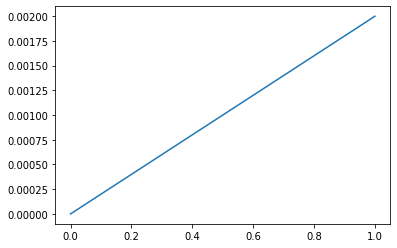

In [16]:
# 事前分布をプロット
import matplotlib.pyplot as plt
plt.plot(thetas,p)

更新式
$$
　p(\theta | r)  = \frac{p(r| \theta)p(\theta)}{p(r)}
$$

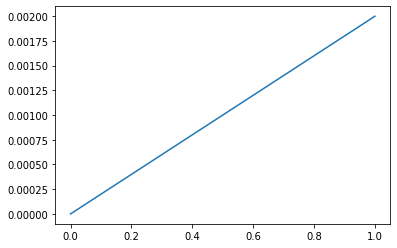

In [15]:
# 事後分布に更新 r=1のとき
p = posterior(1,p)
plt.plot(thetas,p)

In [17]:
clicks = 10
noclicks = 30

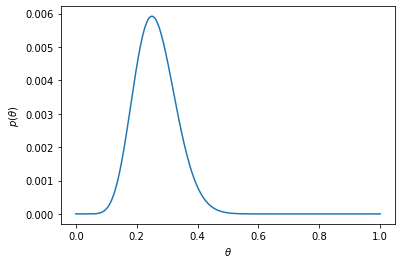

In [18]:
# 一様分布を事前分布として再度設定
p = np.array([1/len(thetas) for _ in thetas])

# r=1
for _ in range(clicks):
    p = posterior(1,p)
# r=0
for _ in range(noclicks):
    p = posterior(0,p)
    
plt.plot(thetas,p)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.show()

In [25]:
# 事後分布の最大値
print(max(p))
print(thetas[np.argmax(p)])

0.005918938200606526
0.25


## 1.5 別解1:繰り返しをまとめる
### 統計モデリング

1.4のベルヌーイ分布の場合
$$
  \theta \sim p(\theta) = Uniform(0,1) \\
  r \sim p(r| \theta) = Bernoulli(\theta)
$$

$\sim$は左辺の確率分布からサンプルされたことを示す

#### 二項分布
ベルヌーイ試行をN回行ったときの成功回数aが従う分布
$$
p(a | \theta , N) = {}_N C _a \theta^a (1-\theta)^{N-a} = Binomial(\theta, N)
$$

統計モデリングとして、記述すると
$$
 \theta \sim Uniform(0,1) \\
 a \sim Binomial(\theta, N)
$$

In [26]:
likelihood = lambda a, N: thetas**a *(1-thetas)**(N-a)

# 事後分布
def posterior(a,N,prior):
    lp = likelihood(a,N)*prior
    return lp/lp.sum()

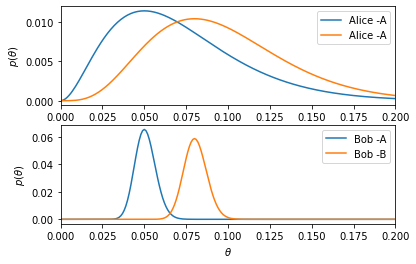

In [28]:
prior = 1/len(thetas)
plt.subplot(2,1,1)
plt.plot(thetas, posterior(2,40,prior), label='Alice -A')
plt.plot(thetas, posterior(4,50,prior), label='Alice -A')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.xlim(0,0.2)
plt.legend()
plt.subplot(2,1,2)
plt.plot(thetas, posterior(64,1280,prior), label='Bob -A')
plt.plot(thetas, posterior(128,1600,prior), label='Bob -B')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.xlim(0,0.2)
plt.legend()

## 1.6　別解2:ベータ分布

$$
p(\theta|a,N) = \frac{\theta^{a}(1-\theta)^{N-a}}{ \int_0^1 \theta^{a}(1-\theta)^{N-a} d\theta}
$$

$$
p(\theta|\alpha,\beta) = Beta(\alpha, \beta) = \frac{\theta^{\alpha-1}(1-\theta)^{\beta-1}}{ \int_0^1 \theta^{\alpha-1}(1-\theta)^{\beta-1} d\theta}
$$

ベータ分布は事前分布から事後分布に更新しても分布の形が変わらない**共役事前分布**


$$
 \theta \sim Beta(1,1) \\
 a \sim Binomial(\theta,N)
$$

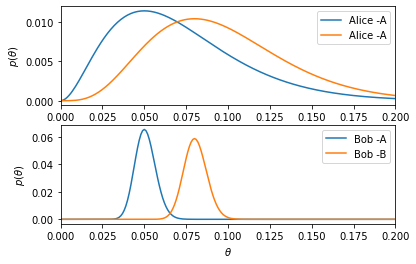

In [30]:
def betaf(alpha,beta):
    numerator = thetas ** (alpha-1) *(1-thetas) ** (beta-1)
    return numerator/numerator.sum()

def posterior(a,N):
    return betaf(a+1, N-a+1)
plt.subplot(2,1,1)
plt.plot(thetas, posterior(2,40), label='Alice -A')
plt.plot(thetas, posterior(4,50), label='Alice -A')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.xlim(0,0.2)
plt.legend()
plt.subplot(2,1,2)
plt.plot(thetas, posterior(64,1280), label='Bob -A')
plt.plot(thetas, posterior(128,1600), label='Bob -B')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.xlim(0,0.2)
plt.legend()

## 1.7 事後分布から決断を下す

In [34]:
def hmv(xs, ps, alpha=0.95):
    xps = sorted(zip(xs, ps), key=lambda xp: xp[1], reverse=True)
    xps = np.array(xps)
    xs = xps[:,0]
    ps = xps[:,1]
    return  np.sort(xs[np.cumsum(ps) <= alpha])

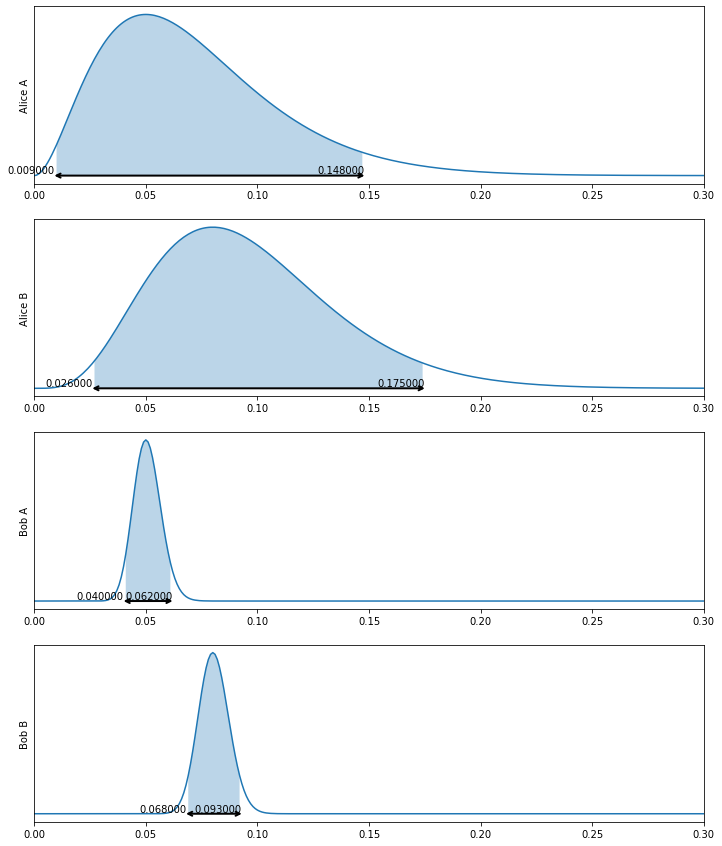

In [40]:
thetas = np.linspace(0,1,1001)

def posterior(a,N):
    alpha = a + 1
    beta = N - a + 1
    numerator = thetas ** (alpha-1) *(1-thetas) ** (beta-1)
    return numerator/numerator.sum()


def plot_hdi(ps,label):
    hm_thetas = hmv(thetas, ps, alpha=0.95)
    plt.plot(thetas,ps)
    plt.annotate('', 
                 xy=(hm_thetas.min(),0),
                 xytext=(hm_thetas.max(),0),
                 arrowprops=dict(color='black',
                                 shrinkA=0,
                                 shrinkB=0,
                                 arrowstyle='<->',
                                 linewidth=2)
                )
    plt.annotate('%3f' % hm_thetas.min(),
                 xy=(hm_thetas.min(),0),
                 ha='right',
                 va='bottom'
                )
    plt.annotate('%3f' % hm_thetas.max(),
             xy=(hm_thetas.max(),0),
             ha='right',
             va='bottom'
            )
    hm_region = (hm_thetas.min() < thetas) & (thetas < hm_thetas.max())
    plt.fill_between(thetas[hm_region], ps[hm_region], 0, alpha=0.3)
    plt.xlim(0,0.3)
    plt.ylabel(label)
    plt.yticks([])

plt.figure(figsize=(12,15))
plt.subplot(4,1,1)
plot_hdi(posterior(2,40), 'Alice A')
plt.subplot(4,1,2)
plot_hdi(posterior(4,50), 'Alice B')   
plt.subplot(4,1,3)
plot_hdi(posterior(64,1280), 'Bob A')
plt.subplot(4,1,4)
plot_hdi(posterior(128,1600), 'Bob B')

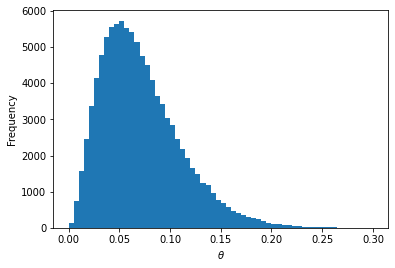

In [42]:
data = np.random.beta(3, 39, size=100000)
plt.hist(data, range=(0,0.3), bins=60)
plt.xlabel(r'$\theta$')
plt.ylabel('Frequency')
plt.show()

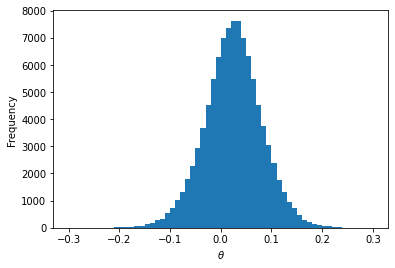

In [43]:
theta_a = np.random.beta(3, 39, size=100000)
theta_b = np.random.beta(5, 47, size=100000)
delta = theta_b - theta_a
plt.hist(delta, range=(-0.3,0.3), bins=60)
plt.xlabel(r'$\theta$')
plt.ylabel('Frequency')
plt.show()

In [44]:
print((delta>0).mean())

0.68257
